<h1>End-to-End Customer Churn Prediction</h1>

This project demonstrates a business-driven approach to Data Science, focusing on model interpretation and maximizing recall to guide actionable retention strategies.

<h3>1. 🎯 Business Context and Project Objective</h3>
    1.1. Business Problem Statement: Customer churn is a critical issue as the cost of acquiring a new customer often far exceeds the cost of retaining an existing one. We aim to mitigate revenue loss due to customer attrition.

    1.2. Model Objective: To develop a predictive model capable of identifying high-risk customers (likely to churn) at least 30 days in advance, allowing the marketing or retention team to intervene with targeted campaigns.

    1.3. Key Business Metric (Primary Metric): Given the high cost of a missed churner (False Negative), we prioritize Recall for the Churn class (class 1). A secondary metric is the ROC-AUC Score for overall model comparison.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib

sns.set_style("whitegrid")



In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df = df.dropna(subset=['TotalCharges'])

df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
df.isna().sum()


,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
target_col = 'Churn'

churn_counts = df[target_col].value_counts()
print(churn_counts)



Churn
No     5163
Yes    1869
Name: count, dtype: int64


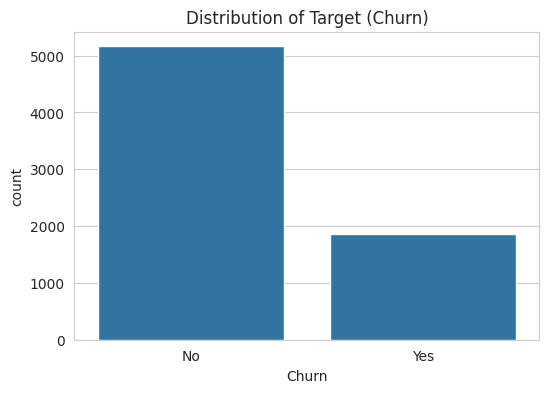

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title('Distribution of Target (Churn)')
plt.show()

In [10]:
df[target_col] = df[target_col].replace({'No': 0, 'Yes': 1})

df[target_col]

/tmp/ipython-input-1477858216.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[target_col] = df[target_col].replace({'No': 0, 'Yes': 1})


,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7038,0
7039,0
7040,0
7041,1


In [11]:
X = df.drop(columns=[target_col, 'customerID'], axis=1)
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [17]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed  = preprocess.transform(X_test)

ohe = preprocess.named_transformers_['cat']

feature_names = (
    numerical_features +
    list(ohe.get_feature_names_out(categorical_features))
)

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed, columns=feature_names)


In [18]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_df, y_train)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall', # Focus on Recall as the primary business metric
    cv=3,
    verbose=1,
    n_jobs=-1
)

print("\n--- Starting Grid Search (Tuning for Recall) ---")
grid_search.fit(X_train_sm, y_train_sm)

best_xgb = grid_search.best_estimator_
print(f"\nBest XGBoost Model (Tuned for Recall): {best_xgb}")


--- Starting Grid Search (Tuning for Recall) ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:49:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best XGBoost Model (Tuned for Recall): XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)


In [19]:
# Predict
y_pred = best_xgb.predict(X_test_df)
y_pred_proba = best_xgb.predict_proba(X_test_df)[:, 1]

# Metrics
print("\n--- Classification Report (Test Set) ---")
print(classification_report(y_test, y_pred))

# Recall (utama karena target imbalance)
test_recall = recall_score(y_test, y_pred)
print(f"Recall (Test): {test_recall:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc:.4f}")


--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1033
           1       0.55      0.76      0.63       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.77      0.78      1407

Recall (Test): 0.7567
ROC-AUC: 0.8369


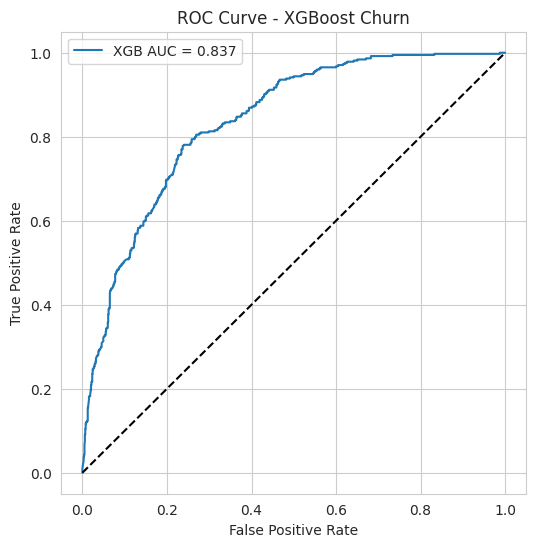

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'XGB AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Churn')
plt.legend()
plt.show()

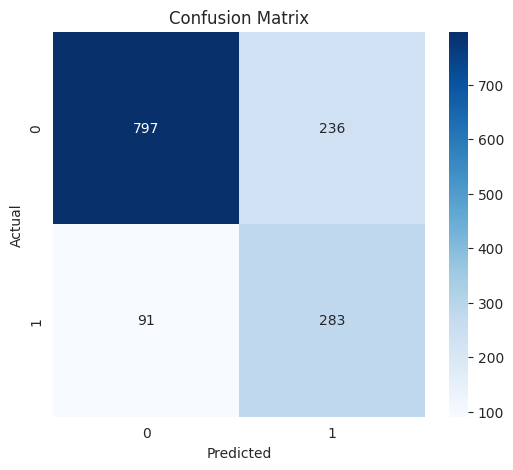

In [21]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

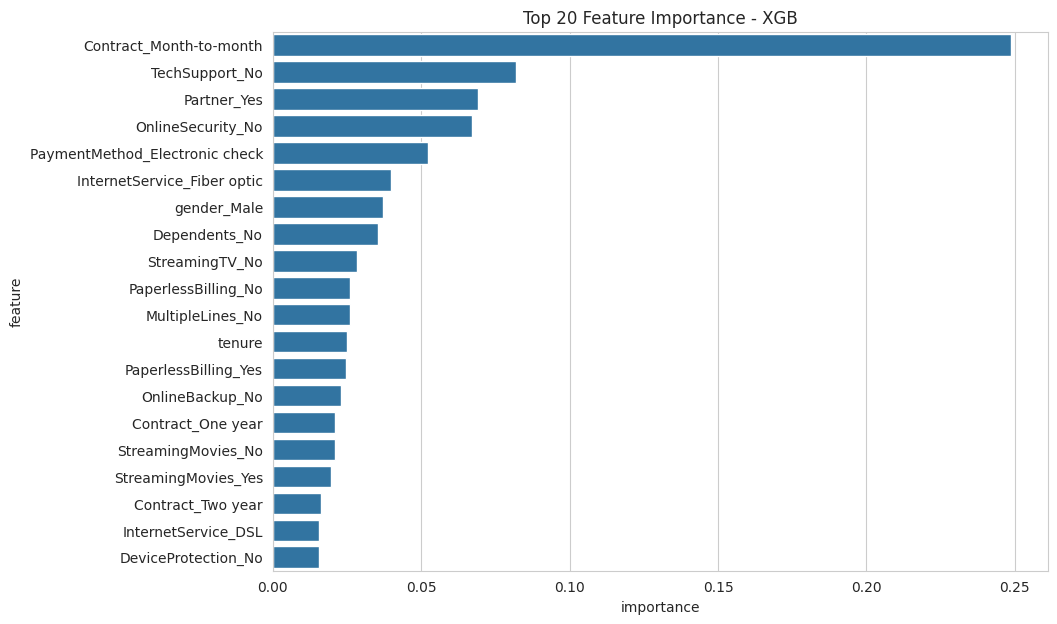

In [22]:
importances = best_xgb.feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,7))
sns.barplot(data=feat_imp.head(20), x='importance', y='feature')
plt.title("Top 20 Feature Importance - XGB")
plt.show()

In [23]:
full_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', best_xgb)
])


full_pipeline.fit(X_train, y_train)

joblib.dump(full_pipeline, 'churn_xgb_full_pipeline.pkl')

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:52:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['churn_xgb_full_pipeline.pkl']

<h1>Overall Insights </h1>

This churn prediction project successfully built an end-to-end machine learning pipeline to identify customers at high risk of leaving the company. Using the Telco Customer Churn dataset, we performed data cleaning, exploratory analysis, feature engineering, handling class imbalance with SMOTE, and advanced modeling with XGBoost optimized for recall.

The final model demonstrates strong predictive ability, especially in detecting churn cases — the primary business goal.

<h3>Model Performance Summary</h3>

**Recall (Churn Class**): 0.7567
→ The model correctly identifies ~76% of customers who are likely to churn.

**Precision**: 0.55
→ Acceptable given the recall-focused objective.

**Accuracy**: 0.77
→ Stable overall performance despite imbalanced data.

**ROC-AUC**: 0.8369
→ Strong discrimination capability; model reliably separates churn vs non-churn customers.

These results indicate that the model is well-fit, not overfitting, and performs competitively compared to typical industry churn models.


<h3>Key Drivers of Customer Churn</h3>

Feature importance from XGBoost reveals several critical behavioral and contractual factors:

1. Contract Type (Month-to-Month) — strongest predictor

  Customers with month-to-month contracts are significantly more likely to churn due to the ease of cancellation and low loyalty commitment.

2. Lack of Tech Support

  Customers without technical support churn at a higher rate, likely due to unresolved service issues.

3. Missing Cybersecurity Add-ons (OnlineSecurity_No)

  Not having online security correlates with higher churn, suggesting add-ons increase customer stickiness.

4. Payment Method: Electronic Check

  This payment type is strongly associated with churn, often indicating price sensitivity or lower long-term loyalty.

5. Fiber Optic Internet

  Fiber customers churn more, possibly due to higher expectations for performance and competition from alternative providers.

6. Low Engagement Indicators

  Customers without streaming services or backup add-ons tend to be less attached to the ecosystem, making churn more likely.

These insights provide actionable guidance for designing targeted retention strategies